# A Quick Look at ZTF Light Curves
This notebook demostrates how to search for ZTF light curve data using the cone-search API provided by [IRSA/IPAC](https://irsa.ipac.caltech.edu/docs/program_interface/ztf_lightcurve_api.html), and then goes through a few steps to perform period identification before generating folded ZTF light curves

In [1]:
import numpy as np
import pandas as pd
import astropy.coordinates as coord
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%matplotlib inline

# IRSA Login Information
Although not necessary to run this notebook, you can provide your credentials for IRSA here if you have an IRSA account. It's only needed if you have access to the Caltech or Partnership ZTF data and would like that data to be included when you query IRSA. Without a login, this code will just download the publically available ZTF data. 

Also, ZTF public data releases are happening every two months at the moment. If you are trying to download data from older releases, keep in mind that IRSA does not store data older than four data releases since the current data release. Querying from DRs older than that will result in an HTTP response error.

In [2]:
USER = ""
PASS = ""

# Import Functions to Download ZTF Data from IRSA and Perform Periodogram Analysis

In [3]:
from utils import get_cookie,download_ZTF
from utils import BaryCorr,LC_normalize
from utils import calc_lsp,optimize_freq
from utils import PhaseFold,PhaseFoldBinned
from utils import lighten_color

# Define Search Coordinates and Query IRSA
A few examples of coordinates are provided below, all for the same object, which can be given in either decimal degrees or HMSDMS format:

*     radec = [291.909583, 34.19494]
*     radec = ['19 27 38.30', '+34 11 41.80']
*     radec = ['19:27:38.30', '+34:11:41.80']

The example object provided here is a 

In [4]:
# Search Coordinates and search radius
radec = ['19 27 38.30', '+34 11 41.80']
radius = 3.0 # arcseconds

if type(radec[0]) == float:
    c = coord.SkyCoord(
        ra=radec[0], 
        dec=radec[1], 
        unit=(u.deg,u.deg),
        frame='icrs'
    )
if type(radec[0]) == str:
    c = coord.SkyCoord(
        ra=radec[0], 
        dec=radec[1],
        unit=(u.hourangle,u.deg), 
        frame='icrs'
    )
ra = c.ra.deg # Search RA
dec = c.dec.deg # Search Dec

# Perform ZTF query
cookie = get_cookie(USER,PASS)
data = download_ZTF(
    ra, 
    dec, 
    radius=radius, 
    irsa_cookie=cookie, 
    release='latest'
)

# Separate light curves by filter and remove poor-quality data
gdata = data[
    (data.filtercode == 'zg') & 
    (data.catflags == 0)
].sort_values(by='bjd').reset_index(drop=True)
rdata = data[
    (data.filtercode == 'zr') & 
    (data.catflags == 0)
].sort_values(by='bjd').reset_index(drop=True)
idata = data[
    (data.filtercode == 'zi') & 
    (data.catflags == 0)
].sort_values(by='bjd').reset_index(drop=True)

# Generate normalized light curves in each filter
gdata = LC_normalize(gdata)
rdata = LC_normalize(rdata)
idata = LC_normalize(idata)

# Get average ZTF coordinates
c = coord.SkyCoord(
    data.ra.mean(),
    data.dec.mean(),
    unit='deg',
    frame='icrs'
)
cstring = c.to_string('hmsdms',sep=':',precision=2)

print('{:4d} g-band Data Points'.format(len(gdata)))
print('{:4d} r-band Data Points'.format(len(rdata)))
print('{:4d} i-band Data Points'.format(len(idata)))

 466 g-band Data Points
 888 r-band Data Points
   0 i-band Data Points


# Plot the ZTF Light Curves

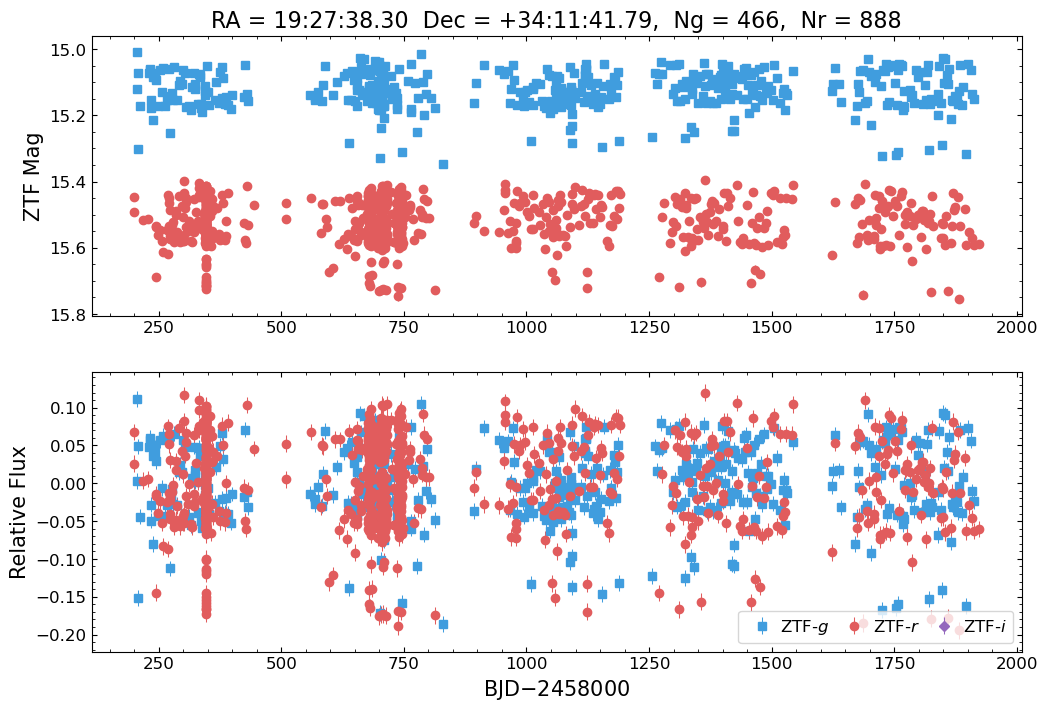

In [5]:
figa = plt.figure('a',figsize=(12,8))
gs = GridSpec(2,1,hspace=0.2)
ax = figa.add_subplot(gs[0])
bx = figa.add_subplot(gs[1])
axlist = [ax,bx]

# Get lightened colors for unbinned data points
lighten_amount = 0.75
gcol = lighten_color('C0',lighten_amount)
rcol = lighten_color('C3',lighten_amount)
icol = lighten_color('C4',lighten_amount+0.25)
alp = 1.0 # alpha value

# Plot g-, r-, & i-band data in magnitude units
ax.errorbar(gdata.bjd-2458000,gdata.mag,yerr=gdata.magerr,
            ls='None',marker='s',ms=6,mfc=gcol,mec=gcol,
            ecolor=gcol,elinewidth=0.75,alpha=alp,
            label='ZTF-$g$')
ax.errorbar(rdata.bjd-2458000,rdata.mag,yerr=rdata.magerr,
            ls='None',marker='o',ms=6,mfc=rcol,mec=rcol,
            ecolor=rcol,elinewidth=0.75,alpha=alp,
            label='ZTF-$r$')
ax.errorbar(idata.bjd-2458000,idata.mag,yerr=idata.magerr,
            ls='None',marker='D',ms=5,mfc=icol,mec=icol,
            ecolor=icol,elinewidth=0.75,alpha=alp,
            label='ZTF-$i$')

# Plot g-, r-, & i-band data in relative flux units
bx.errorbar(gdata.bjd-2458000,gdata.flux,yerr=gdata.fluxerr,
            ls='None',marker='s',ms=6,mfc=gcol,mec=gcol,
            ecolor=gcol,elinewidth=0.75,alpha=alp,
            label='ZTF-$g$')
bx.errorbar(rdata.bjd-2458000,rdata.flux,yerr=rdata.fluxerr,
            ls='None',marker='o',ms=6,mfc=rcol,mec=rcol,
            ecolor=rcol,elinewidth=0.75,alpha=alp,
            label='ZTF-$r$')
bx.errorbar(idata.bjd-2458000,idata.flux,yerr=idata.fluxerr,
            ls='None',marker='D',ms=5,mfc=icol,mec=icol,
            ecolor=icol,elinewidth=0.75,alpha=alp,
            label='ZTF-$i$')

# Set plot appearances
for i,p in enumerate(axlist):
    p.minorticks_on()
    p.tick_params(
        which='both',
        axis='both',
        direction='in',
        right=True,
        top=True,
        labelsize=12
    )
    
    if i == 0:
        p.set_ylim(p.get_ylim()[::-1])
        p.set_ylabel('ZTF Mag',fontsize=15)
    elif i == 1:
        p.set_xlabel('BJD$-$2458000',fontsize=15)
        p.set_ylabel('Relative Flux',fontsize=15)
        
bx.legend(loc='lower right',
          fontsize=12,
          handletextpad=0.1,
          numpoints=1,
          ncol=3,
          markerscale=1,
          columnspacing=0.5)

# Create Plot Title With Coordinates and Data Counts
title_a = 'RA = {}  Dec = {},  Ng = {},  Nr = {}'.format(
    cstring.split(" ")[0],
    cstring.split(" ")[1],
    len(gdata),
    len(rdata)
)
ax.set_title(title_a,fontsize=16);

# Calculate Lomb Scargle Periodgrams for the *g, r*, and combined ZTF Light Curves

In [6]:
# Combine g- and r-band BJD times and normalized flux arrays
tsec_combined = np.concatenate(
    (gdata.bsec.values,
     rdata.bsec.values)
)
sort_ind = np.argsort(tsec_combined)
tsec_combined = tsec_combined[sort_ind]

flux_combined = np.concatenate(
    (gdata.flux.values,
     rdata.flux.values)
)[sort_ind]

# Calculate LSP for g, r, & combined light curves
trange = max(tsec_combined) - min(tsec_combined)
fnyquist = 0.005
ofactor = 3.
fres = (1./trange) / ofactor
farr = np.linspace(fres,fnyquist,int(fnyquist/fres))
glsp = calc_lsp(gdata.bsec.values,gdata.flux.values,farr)
rlsp = calc_lsp(rdata.bsec.values,rdata.flux.values,farr)
clsp = calc_lsp(tsec_combined,flux_combined,farr)

# Pick Out the Highest-Peak Frequency and Optimize It Using LMFIT

In [7]:
# Pick out the frequency and amplitude of the highest peak
max_freq = farr[clsp == max(clsp)][0]
max_amp = max(clsp)

# Fit sinusoidal function to data
freq_fit, clsp_pw = optimize_freq(
    tsec_combined, 
    flux_combined, 
    farr, 
    max_freq, 
    max_amp)

  Initial Frequency: 178.211425 uHz
Optimized Frequency: 178.211229 uHz
  Initial Period   : 93.5219 min
Optimized Period   : 93.5220 min


# Plot the Normalized ZTF Light Curves and Lomb-Scargle Periodograms

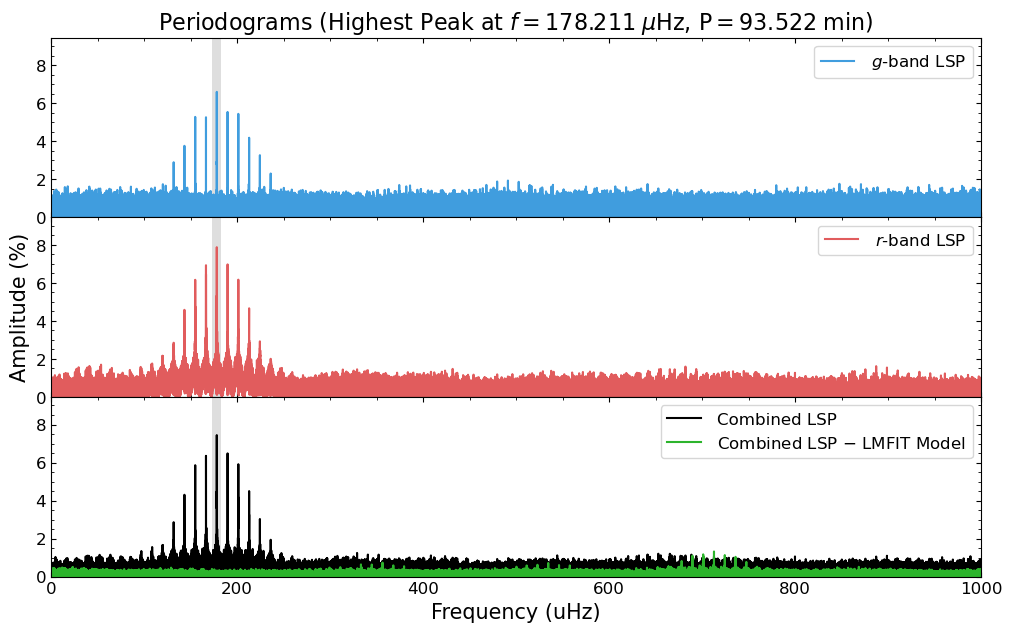

In [8]:
figb = plt.figure('b',figsize=(12,7))
gsb = GridSpec(3,1,hspace=0)
ax = figb.add_subplot(gsb[0])
bx = figb.add_subplot(gsb[1])
cx = figb.add_subplot(gsb[2])
axlist = [ax,bx,cx]


# Plot the Lomb-Scargle Periodograms
ax.plot(farr*1e6,glsp*1e2,ls='-',c=gcol,label='$g$-band LSP')
bx.plot(farr*1e6,rlsp*1e2,ls='-',c=rcol,label='$r$-band LSP')
cx.plot(farr*1e6,clsp*1e2,ls='-',c='k',label='Combined LSP')
cx.plot(farr*1e6,clsp_pw*1e2,ls='-',c=lighten_color('forestgreen',0.85),
        label='Combined LSP $-$ LMFIT Model')


for i,p in enumerate(axlist):
    
    # Add legend
    p.legend(
        loc='upper right',
        fontsize=12,
        handletextpad=1,
        numpoints=1,
        columnspacing=0.5)
    
    if i == 1:
        p.set_ylabel('Amplitude (%)',fontsize=15)
    elif i == 2:
        p.set_xlabel('Frequency (uHz)',fontsize=15)
    if freq_fit < 0.0006:
        if fnyquist < 0.001:
            p.set_xlim(0,fnyquist*1e6)
        else:
            p.set_xlim(0,1000)
    else:
        p.set_xlim(0,fnyquist*1e6)
    p.set_ylim(0,1.2*max([max(glsp),max(rlsp),max(clsp)])*1e2)
    
    # Mark best-fit frequency
    xrange = p.get_xlim()[1] - p.get_xlim()[0]
    p.fill_between(
        [freq_fit*1e6-0.005*xrange, freq_fit*1e6+0.005*xrange],
        [0.0,0.0],
        y2=p.get_ylim()[1],
        fc='C7',
        ec='None',
        lw=0,
        alpha=0.25
    )

    lb=False
    if i == 2:
        lb=True
    p.minorticks_on()
    p.tick_params(which='both',axis='both',direction='in',
                  right=True,top=True,labelbottom=lb,labelsize=12)
        
# Add Basic Title
title = 'Periodograms (Highest Peak at $f = {:.3f}\;\mu$Hz, P$={:.3f}\;$min) '.format(
    freq_fit*1e6,
    1./freq_fit/60)
ax.set_title(title,fontsize=16);

# Plot Two Cycles of the Phase Folded ZTF Light Curve
Also plotting three light curves folded on three different periods (1/2, 1 and 2 times the best-fit period from above)

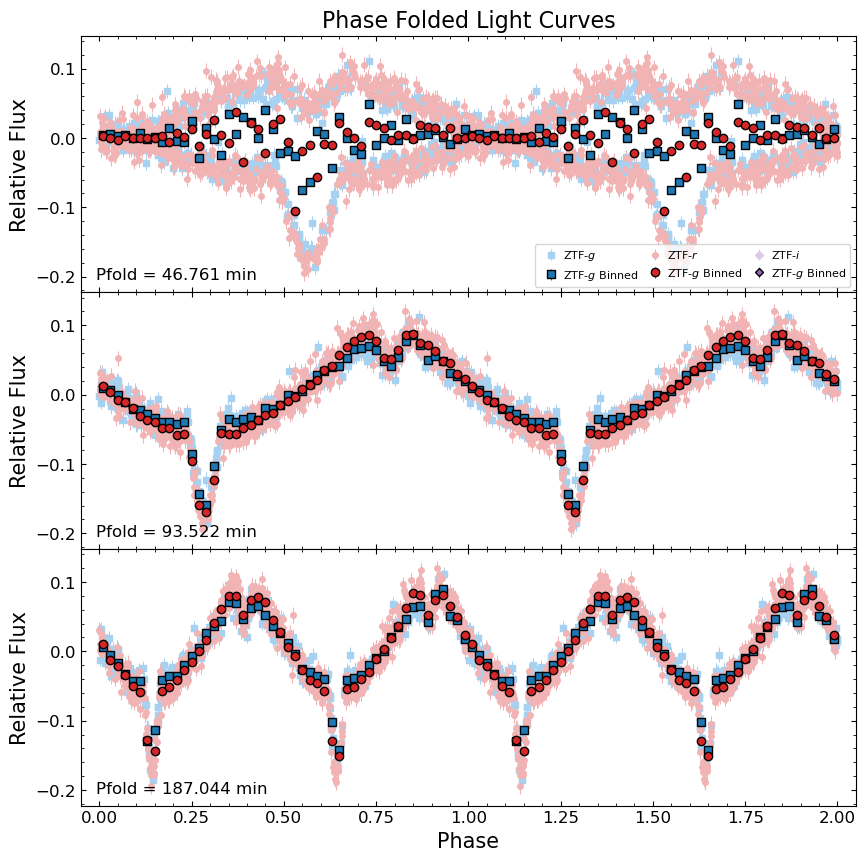

In [10]:
figc = plt.figure('c',figsize=(10,10))
gs = GridSpec(3,1,hspace=0.0)
ax = figc.add_subplot(gs[0])
bx = figc.add_subplot(gs[1])
cx = figc.add_subplot(gs[2])
axlist = [ax,bx,cx]

# Plot the Phase Folded ZTF Light Curves
pfactors = [0.5, 1.0, 2.0]
for pnum,pfac in enumerate(pfactors):
    
    # Get plotting axis
    p = axlist[pnum]
    
    # Designate a folding period using the result from LMFIT
    pfold = pfac * (1./freq_fit)

    # Calculate the phases
    phases_g = PhaseFold(gdata.bsec.values, pfold, t0=0.0)
    phases_r = PhaseFold(rdata.bsec.values, pfold, t0=0.0)
    phases_i = PhaseFold(idata.bsec.values, pfold, t0=0.0)

    # Calculate binned light curves
    t0 = 0.0
    nbins = 50
    binnedLC_g = PhaseFoldBinned(
        gdata.bsec.values, 
        gdata.flux.values, 
        gdata.fluxerr.values, 
        pfold, t0=t0, nbin=nbins)
    binnedLC_r = PhaseFoldBinned(
        rdata.bsec.values, 
        rdata.flux.values, 
        rdata.fluxerr.values, 
        pfold, t0=t0, nbin=nbins)
    binnedLC_i = PhaseFoldBinned(
        idata.bsec.values, 
        idata.flux.values, 
        idata.fluxerr.values, 
        pfold, t0=t0, nbin=nbins)
    
    for i in range(2):

        # Set labels for each data set
        if i == 0:
            labels = ['ZTF-$g$','ZTF-$r$','ZTF-$i$']
        else:
            labels = ['_none','_none','_none']
            
        # Get lightened colors for unbinned data points
        lighten_amount = 0.35
        gcol = lighten_color('C0',lighten_amount)
        rcol = lighten_color('C3',lighten_amount)
        icol = lighten_color('C4',lighten_amount)
        
        # Plot g-band
        p.errorbar(phases_g+float(i),gdata.flux.values,yerr=gdata.fluxerr.values,
                    ls='None',marker='s',ms=4,mfc=gcol,mec=gcol,
                    ecolor=gcol,elinewidth=0.75,alpha=1,zorder=-10,
                    label=labels[0])
        p.errorbar(binnedLC_g[:,0]+float(i),binnedLC_g[:,1],yerr=binnedLC_g[:,2],
                    ls='None',marker='s',ms=6,mfc='C0',mec='k',
                    ecolor='C0',elinewidth=0.75,alpha=1,zorder=10,
                    label=labels[0]+" Binned")
        
        # Plot r-band
        p.errorbar(phases_r+float(i),rdata.flux.values,yerr=rdata.fluxerr.values,
                    ls='None',marker='o',ms=4,mfc=rcol,mec=rcol,
                    ecolor=rcol,elinewidth=0.75,alpha=1,zorder=-10,
                    label=labels[1])
        p.errorbar(binnedLC_r[:,0]+float(i),binnedLC_r[:,1],yerr=binnedLC_r[:,2],
                    ls='None',marker='o',ms=6,mfc='C3',mec='k',
                    ecolor='C3',elinewidth=0.75,alpha=1,zorder=10,
                    label=labels[0]+" Binned")
        
        # Plot i-band
        p.errorbar(phases_i+float(i),idata.flux.values,yerr=idata.fluxerr.values,
                    ls='None',marker='D',ms=4,mfc=icol,mec=icol,
                    ecolor=icol,elinewidth=0.75,alpha=1,zorder=-10,
                    label=labels[2])
        p.errorbar(binnedLC_i[:,0]+float(i),binnedLC_i[:,1],yerr=binnedLC_i[:,2],
                    ls='None',marker='D',ms=4.5,mfc='C4',mec='k',
                    ecolor='C4',elinewidth=0.75,alpha=1,zorder=10,
                    label=labels[0]+" Binned")

        
    # Set plot appearances
    pfold_text = 'Pfold = {:.3f} min'.format(pfold/3600*60)
    p.text(0.02, 0.05, pfold_text, transform=p.transAxes, fontsize=12)
    p.set_ylabel('Relative Flux',fontsize=15)
    p.set_xlim(-0.05,2.05)
    p.minorticks_on()
    p.tick_params(
        which='both',
        axis='both',
        direction='in',
        right=True,
        top=True,
        labelsize=12
    )

# Add Basic Title
title = 'Phase Folded Light Curves'.format(pfold/3600*60)
ax.set_title(title,fontsize=16)

# Add a legend
ax.legend(loc='lower right',
          fontsize=8,
          handletextpad=0.1,
          numpoints=1,
          ncol=3,
          markerscale=1,
          columnspacing=0.5)

cx.set_xlabel('Phase',fontsize=15);